# Fine-tuning a model for Sentence Similarity and Information Retrieval

In this notebook, we will fine-tune a sentence transformer model for document similarity tasks, specifically for the RepositoriUM collection. We'll use a pre-trained model and fine-tune it on pairs of document abstracts with similarity scores.

The completed system will allow us to:
1. Process document collections from RepositoriUM
2. Train a similarity model on document pairs
3. Retrieve relevant documents based on a query

In [1]:
# Install required packages
!pip install datasets transformers matplotlib sentence-transformers pandas numpy tqdm evaluate huggingface_hub torch 'accelerate>=0.26.0'

In [2]:
import transformers
import sentence_transformers
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("sentence_similarity_notebook", framework="pytorch")

## Configuring the Model

We'll set the parameters for our model training. For best results in sentence similarity tasks, we should use a pre-trained sentence-transformer model:

In [4]:
# Model configuration
model_checkpoint = "paraphrase-multilingual-MiniLM-L12-v2"
batch_size = 16
max_length = 512

# Training parameters
num_epochs = 3
warmup_ratio = 0.1
learning_rate = 2e-5
weight_decay = 0.01

## Loading the Dataset

First, we need to load the training data that was created by our `process_data.py` script.
This data consists of pairs of document abstracts with similarity scores.

In [5]:
import json
import pandas as pd
import os
from pathlib import Path

data_dir = Path("data")
train_file = data_dir / "training_data.json"

try:
    with open(train_file, 'r', encoding='utf-8') as f:
        training_data = json.load(f)

    print(f"Loaded {len(training_data)} document pairs")
    
    train_df = pd.DataFrame([
        {"abstract1": item[0], "abstract2": item[1], "similarity": float(item[2])}
        for item in training_data
    ])

except Exception as e:
    print(f"Error loading training data: {e}")
    print("Please run process_data.py first to create the training data, or check the file path")

Loaded 500 document pairs


Let's examine the distribution of similarity scores to understand our data better:

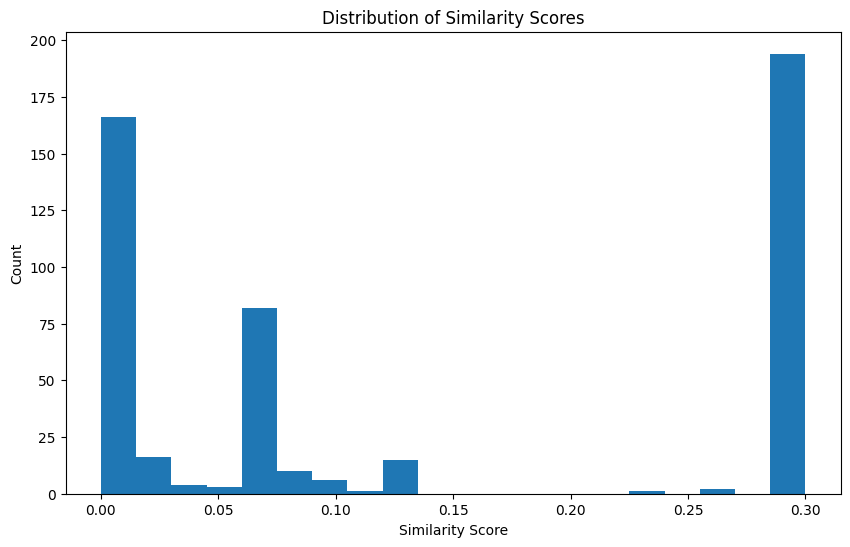

Min similarity: 0.0
Max similarity: 0.3
Mean similarity: 0.1371096928071928
Median similarity: 0.06666666666666667


In [6]:
import matplotlib.pyplot as plt

if len(train_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.hist(train_df['similarity'], bins=20)
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Count')
    plt.show()

    print(f"Min similarity: {train_df['similarity'].min()}")
    print(f"Max similarity: {train_df['similarity'].max()}")
    print(f"Mean similarity: {train_df['similarity'].mean()}")
    print(f"Median similarity: {train_df['similarity'].median()}")
else:
    print("Not enough data to display similarity distribution.")

Now, let's prepare the data for training by splitting it into training and validation sets:

In [7]:
from sklearn.model_selection import train_test_split

if len(train_df) < 10:
    print("Warning: Not enough data for a meaningful split. Consider generating more data.")
    # Create a simple split for demonstration
    train_data = train_df.iloc[:int(len(train_df)*0.8)]
    val_data = train_df.iloc[int(len(train_df)*0.8):]
else:
    # Split data into train and validation sets
    train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Training data: {len(train_data)} pairs")
print(f"Validation data: {len(val_data)} pairs")

Training data: 400 pairs
Validation data: 100 pairs


## Preparing the Model for Training

In [8]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
import torch
import time

device_str = "cuda" if torch.cuda.is_available() else "cpu"

try:
    model = SentenceTransformer(model_checkpoint, device=device_str)
    print(f"Model successfully loaded: {model}")
    
    print(f"Model is on device: {next(model.parameters()).device}")

    train_examples = []
    for _, row in train_data.iterrows():
        abstract1 = str(row['abstract1']) if not isinstance(row['abstract1'], str) else row['abstract1']
        abstract2 = str(row['abstract2']) if not isinstance(row['abstract2'], str) else row['abstract2']
        
        train_examples.append(InputExample(
            texts=[abstract1, abstract2],
            label=float(row['similarity'])
        ))

    val_examples = []
    for _, row in val_data.iterrows():
        abstract1 = str(row['abstract1']) if not isinstance(row['abstract1'], str) else row['abstract1']
        abstract2 = str(row['abstract2']) if not isinstance(row['abstract2'], str) else row['abstract2']
        
        val_examples.append(InputExample(
            texts=[abstract1, abstract2],
            label=float(row['similarity'])
        ))

    # Define a custom collate function for InputExample objects
    def collate_fn(batch):
        texts = [example.texts for example in batch]
        labels = [example.label for example in batch]
        return {"texts": texts, "labels": torch.tensor(labels)}

    # Create DataLoader for training with the custom collate function
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)

    evaluator = EmbeddingSimilarityEvaluator(
        sentences1=[ex.texts[0] for ex in val_examples],
        sentences2=[ex.texts[1] for ex in val_examples],
        scores=[ex.label for ex in val_examples]
    )
    
    print(f"Prepared {len(train_examples)} training examples and {len(val_examples)} validation examples")
except Exception as e:
    print(f"Error preparing model: {e}")
    raise

Model successfully loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
Model is on device: cpu
Prepared 400 training examples and 100 validation examples


In [9]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
import torch
import time

device_str = "cuda" if torch.cuda.is_available() else "cpu"

try:
    model = SentenceTransformer(model_checkpoint, device=device_str)
    print(f"Model successfully loaded: {model}")
    
    print(f"Model is on device: {next(model.parameters()).device}")

    train_examples = []
    for _, row in train_data.iterrows():
        abstract1 = str(row['abstract1']) if not isinstance(row['abstract1'], str) else row['abstract1']
        abstract2 = str(row['abstract2']) if not isinstance(row['abstract2'], str) else row['abstract2']
        
        train_examples.append(InputExample(
            texts=[abstract1, abstract2],
            label=float(row['similarity'])
        ))

    val_examples = []
    for _, row in val_data.iterrows():
        abstract1 = str(row['abstract1']) if not isinstance(row['abstract1'], str) else row['abstract1']
        abstract2 = str(row['abstract2']) if not isinstance(row['abstract2'], str) else row['abstract2']
        
        val_examples.append(InputExample(
            texts=[abstract1, abstract2],
            label=float(row['similarity'])
        ))

    # Define a custom collate function for InputExample objects
    def collate_fn(batch):
        texts = [example.texts for example in batch]
        labels = [example.label for example in batch]
        return {"texts": texts, "labels": torch.tensor(labels)}

    # Create DataLoader for training with the custom collate function
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)

    evaluator = EmbeddingSimilarityEvaluator(
        sentences1=[ex.texts[0] for ex in val_examples],
        sentences2=[ex.texts[1] for ex in val_examples],
        scores=[ex.label for ex in val_examples]
    )
    
    print(f"Prepared {len(train_examples)} training examples and {len(val_examples)} validation examples")
except Exception as e:
    print(f"Error preparing model: {e}")
    raise

Model successfully loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
Model is on device: cpu
Prepared 400 training examples and 100 validation examples


## Training the Model

In [ ]:
from sentence_transformers import losses
import os
from datetime import datetime

# Create an output directory for saving the model
output_dir = os.path.join("information_retrieval/output", "repositorium-similarity-model")
os.makedirs(output_dir, exist_ok=True)

# Calculate number of warmup steps
num_training_steps = len(train_dataloader) * num_epochs
warmup_steps = int(num_training_steps * warmup_ratio)

# Define loss function (CosineSimilarityLoss for regression of similarity scores)
train_loss = losses.CosineSimilarityLoss(model=model)

# Start training
print(f"Starting training at {datetime.now()}")
print(f"Total steps: {num_training_steps}, Warmup steps: {warmup_steps}")

try:
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=num_epochs,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay, 
        output_path=output_dir,
        optimizer_params={'lr': learning_rate},
        show_progress_bar=True,
        evaluation_steps=25,
        save_best_model=True
    )
    
    print(f"Training completed. Model saved to {output_dir}")

except Exception as e:
    print(f"Error during training: {e}")

Starting training at 2025-06-17 18:51:21.892600
Total steps: 75, Warmup steps: 7


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
25,No log,No log,0.081050,0.076317
50,No log,No log,0.140475,0.133713


## Evaluating the Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

# Load the best model (if available)
try:
    best_model_path = os.path.join(output_dir)
    if os.path.exists(best_model_path):
        model = SentenceTransformer(best_model_path)
        print(f"Loaded best model from {best_model_path}")
except Exception as e:
    print(f"Could not load best model. Using current model. Error: {e}")

# Evaluation on validation set
print("Evaluating model on validation set...")

# Get embeddings for validation texts
sentences1 = [ex.texts[0] for ex in val_examples]
sentences2 = [ex.texts[1] for ex in val_examples]
gold_scores = [ex.label for ex in val_examples]

# Get embeddings and calculate cosine similarities
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

cosine_scores = []
for i in range(len(embeddings1)):
    cosine_score = torch.nn.functional.cosine_similarity(embeddings1[i].unsqueeze(0), 
                                                        embeddings2[i].unsqueeze(0)).item()
    cosine_scores.append(cosine_score)

# Calculate correlation metrics
pearson_corr, pearson_p = pearsonr(gold_scores, cosine_scores)
spearman_corr, spearman_p = spearmanr(gold_scores, cosine_scores)

print(f"Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.4f})")
print(f"Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")

# Sample predictions
print("\nSample predictions:")
for i in range(min(5, len(val_examples))):
    print(f"Text 1: {sentences1[i][:50]}...")
    print(f"Text 2: {sentences2[i][:50]}...")
    print(f"Gold score: {gold_scores[i]:.4f}, Predicted: {cosine_scores[i]:.4f}")
    print("-" * 80)

# Save evaluation metrics
evaluation_results = {
    "pearson_correlation": pearson_corr,
    "spearman_correlation": spearman_corr,
    "num_validation_examples": len(val_examples)
}

Loaded best model from information_retrieval/output/repositorium-similarity-model
Evaluating model on validation set...
Pearson correlation: 0.1495 (p=0.1376)
Spearman correlation: 0.1562 (p=0.1207)

Sample predictions:
Text 1: ['the 2d convection-diffusion is a well-known prob...
Text 2: ['a visualização de relatórios de meios complement...
Gold score: 0.1000, Predicted: 0.1504
--------------------------------------------------------------------------------
Text 1: ['on a business context, it is responsibility of t...
Text 2: ['the reconstruction of genomic-scale metabolic mo...
Gold score: 0.0000, Predicted: 0.0415
--------------------------------------------------------------------------------
Text 1: ['o koha é um software com interface web para gest...
Text 2: ['devido à elevada proliferação tecnológica, exist...
Gold score: 0.3000, Predicted: 0.1817
--------------------------------------------------------------------------------
Text 1: ['real-time monitoring has become one of th

## Information Retrieval Function

In [ ]:
def retrieve(query, documents, top_k=5, model=model):
    try:
        if not documents:
            print("Warning: Empty document list provided")
            return []
            
        query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=False)
        
        # Get document abstracts
        doc_abstracts = []
        for doc in documents:
            abstract = doc.get('dc.description.abstract', '')
            # Skip empty abstracts
            if abstract:
                doc_abstracts.append(abstract)
            
        # Encode all documents
        doc_embeddings = model.encode(doc_abstracts, 
                                     convert_to_tensor=True, 
                                     show_progress_bar=(len(doc_abstracts) > 10))
        
        # Calculate similarities
        import torch.nn.functional as F
        similarities = F.cosine_similarity(query_embedding.unsqueeze(0), doc_embeddings)
        
        # Sort by similarity
        results = []
        for i, sim in enumerate(similarities):
            # Find the original document that corresponds to this abstract
            for j, doc in enumerate(documents):
                if doc.get('dc.description.abstract', '') == doc_abstracts[i]:
                    results.append((doc, sim.item()))
                    break
        
        # Return top k results
        return sorted(results, key=lambda x: x[1], reverse=True)[:top_k]
    
    except Exception as e:
        print(f"Error in retrieve function: {e}")
        return []

## Testing the Information Retrieval

In [ ]:
# Load document collection
collection_file = data_dir / "col_1822_21316_processed.json"

try:
    with open(collection_file, 'r', encoding='utf-8') as f:
        documents = json.load(f)
    print(f"Loaded {len(documents)} documents")
        
except Exception as e:
    print(f"Error loading document collection: {e}")
    print("Creating empty document list")
    documents = []

Loaded 1000 documents


In [ ]:
queries = [
    "processamento de linguagem natural",
    "web performance optimization",
    "machine learning applications"
]

for query in queries:
    print(f"\n{'='*80}")
    print(f"Query: '{query}'")
    print(f"{'='*80}")
    
    try:
        results = retrieve(query, documents, top_k=3)
        
        if results:
            print(f"Top {len(results)} results:")
            for i, (doc, sim) in enumerate(results, 1):
                print(f"\nDocument {i} - Similarity: {sim:.4f}")
                print(f"Title: {doc.get('dc.title', 'No title')}")
                print(f"Authors: {doc.get('dc.contributor.author', 'Unknown')}")
                
                abstract = doc.get('dc.description.abstract', 'No abstract')
                if len(abstract) > 200:
                    print(f"Abstract: {abstract[:200]}...")
                else:
                    print(f"Abstract: {abstract}")
                    
                print(f"Keywords: {doc.get('dc.subject', 'None')}")
        else:
            print("No results found for this query.")
    
    except Exception as e:
        print(f"Error testing retrieval: {e}")


Query: 'processamento de linguagem natural'


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Top 3 results:

Document 1 - Similarity: 0.5115
Title: unfuzzying fuzzy parsing
Authors: carvalho, pedro miguel de jesus ventura
Abstract: ['recognizing sentences of a language in an efficient and precise manner has always been a strong subject within computer science. many theories, algorithms and techniques have been proposed along computing history, but at the end it all comes down to performing lexical and syntactic analysis of the source, originating a parse tree as the result. sometimes there is no need for full precision or even a full parse tree. a good example of one of these cases is architecture extraction from source code. in this case only a small portion of the code is of interest. another good example is recognizing handwritten expressions, because it is entirely impossible to predict the kind of calligraphy that will be analyzed, it is also impossible to perform an one hundred percent precise recognition. this need for tolerant parsing lead to the development of many fo

Batches: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Top 3 results:

Document 1 - Similarity: 0.3808
Title: on the performance of webassembly
Authors: macedo, joão gonçalves de
Abstract: ['the worldwide web has dramatically evolved in recent years. web pages are dynamic, expressed by pro grams written in common programming languages given rise to sophisticated web applications. thus, web browsers are almost operating systems, having to interpret/compile such programs and execute them. although javascript is widely used to express dynamic web pages, it has several shortcomings and performance inefficiencies. to overcome such limitations, major it powerhouses are developing a new portable and size/load efficient language: webassembly. in this dissertation, we conduct the first systematic study on the energy and run-time performance of webassembly and javascript on the web. we used micro-benchmarks and real applications to have more realistic results. the results show that webassembly, while still in its infancy, is starting to already outp

Batches: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Top 3 results:

Document 1 - Similarity: 0.5999
Title: in-vehicle object detection with yolo algorithm
Authors: farinha, joão simões
Abstract: ['with the growing computational power that we have at our disposal and the ever-increasing amount of data available the field of machine learning has given rise to deep learning, a subset of machine learning algorithms that have shown extraordinary results in a variety of applications from natural language processing to computer vision. in the field of computer vision, these algorithms have greatly improved the state-of-the-art accuracy in tasks associated with object recognition such as detection. this thesis makes use of one of these algorithms, specifically the yolo algorithm, as a basis in the development of a system capable of detecting objects laying inside a car cockpit. to this end a dataset is collected for the purpose of training the yolo algorithm on this task. a comparative analysis of the detection performance of the yolov2 and yol